# Import Statements

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.io as pio
import re
import xml.etree.ElementTree as ET

# Data Exploration

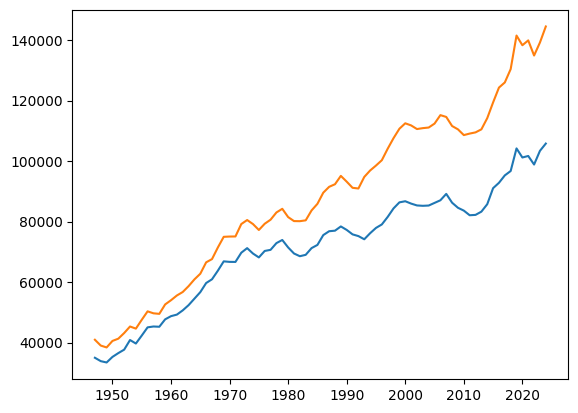

In [2]:
#Load Data
Income_Path = "Data/Income/income_data.csv"
df = pd.read_csv(Income_Path)
df = df[df['Race'] == 'All Races']
df.head()

#Plot Mean & Median Household Income Over Time
years = df['Year'].values
income1 = df['Median_CPI'].values
income2 = df['Mean_CPI'].values
plt.plot(years, income1)
plt.plot(years, income2)

# Making the Animated Sankey Diagram

Family Income Data: https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-families.html
<br>
Expenditure Data: https://apps.bea.gov/iTable/?reqid=19&step=2&isuri=1&categories=underlying&_gl=1

The above two datasets were processed into the sankey data, the script was run over break is is sadly on my PC at home, I do have the original income data (Data/Income/income_data.csv)

In [ ]:
#Load data
frames_df = pd.read_csv("Data/Sankey/sankey_frames_long_1959_2024_usercats.csv")
nodes_df  = pd.read_csv("Data/Sankey/sankey_nodes_usercats.csv").sort_values("node_id")
links_df  = pd.read_csv("Data/Sankey/sankey_links_schema_usercats.csv").sort_values("link_order")


#Prepare data
years = sorted(frames_df["Year"].unique())
cats  = links_df["target_label"].tolist()
source = links_df["source_node"].tolist()
target = links_df["target_node"].tolist()
link_colors = links_df["color"].tolist()
labels = nodes_df["label"].tolist()


#Helper functions
def money(x): return f"${x:,.0f}"

def values_for_year(y):
    sub = frames_df[frames_df["Year"] == y].sort_values("link_order")
    return sub["Value"].astype(float).tolist()

def table_for_year(y):
    vals = values_for_year(y)
    income = sum(vals)
    col_cat = ["Median income"] + cats
    col_val = [money(income)] + [money(v) for v in vals]
    return col_cat, col_val


#Initial data for year 0
y0 = years[0]
v0 = values_for_year(y0)
tcat0, tval0 = table_for_year(y0)


#Initialize figure components
sankey = go.Sankey(
    arrangement="fixed",
    domain=dict(x=[0.00, 0.74], y=[0.00, 1.00]),
    textfont=dict(size=16, color="#111"),
    node=dict(
        label=labels,
        pad=30,
        thickness=40,
        color="rgba(245,245,245,1)",
        line=dict(color="rgba(0,0,0,0.25)", width=1),
        x=nodes_df["x"].tolist(),
        y=nodes_df["y"].tolist(),
    ),
    link=dict(
        source=source,
        target=target,
        value=v0,
        color=link_colors,
        hovertemplate="%{target.label}<br>$%{value:,.0f}<extra></extra>",
    ),
)


#Initial table for year 0
table = go.Table(
    domain=dict(x=[0.76, 1.00], y=[0.00, 1.00]),
    header=dict(
        values=[f"<b>Category</b>", f"<b>{y0}</b>"],
        fill_color="rgba(240,240,240,1)",
        align=["left","right"],
        font=dict(size=14, color="#111"),
        height=28,
    ),
    cells=dict(
        values=[tcat0, tval0],
        fill_color="rgba(255,255,255,1)",
        align=["left","right"],
        font=dict(size=14, color="#111"),
        height=24,
    ),
)
fig = go.Figure(data=[sankey, table])


#Build frames
frames_list = []
for y in years:
    v = values_for_year(y)
    tcat, tval = table_for_year(y)
    frames_list.append(
        go.Frame(
            name=str(y),
            data=[
                go.Sankey(link=dict(value=v)),
                go.Table(
                    header=dict(values=[f"<b>Category</b>", f"<b>{y}</b>"]),
                    cells=dict(values=[tcat, tval]),
                ),
            ],
            traces=[0, 1],
        )
    )
fig.frames = frames_list


#Slider
steps = [
    dict(
        method="animate",
        args=[[str(y)], dict(
            mode="immediate",
            frame=dict(duration=250, redraw=True),
            transition=dict(duration=250),
        )],
        label=str(y),
    )
    for y in years
]


#Final layout
fig.update_layout(
    title="Median Family Income and Household Expenditures (1959–2024)",
    height=950,
    width=1400,
    paper_bgcolor="white",
    font=dict(size=16, color="#111"),
    margin=dict(l=10, r=10, t=60, b=40),
    sliders=[dict(active=0, pad=dict(t=40), steps=steps)],
    updatemenus=[dict(
        type="buttons",
        showactive=False,
        buttons=[
            dict(label="Play", method="animate",
                 args=[None, dict(fromcurrent=True,
                                  frame=dict(duration=250, redraw=True),
                                  transition=dict(duration=250))]),
            dict(label="Pause", method="animate",
                 args=[[None], dict(mode="immediate",
                                    frame=dict(duration=0, redraw=True),
                                    transition=dict(duration=0))]),
        ],
    )],
)


#Show and save figure
fig.show()
#fig.write_html("animated_sankey_responsive.html", include_plotlyjs="cdn")

c:\Users\Owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\kaleido\_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




# Making Bump Plot

Same Data Sources as Previous

In [ ]:
#Load data
df = pd.read_csv("Data/Sankey/sankey_frames_long_1959_2024_usercats.csv").rename(columns={"Target":"Category"})


#Select years + categories to include
years_sel = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
cats = ["Housing","Food","Transportation","Education","Child Care","Insurance","Recreation","Clothing","Furniture","Other"]


#Keep only the years + categories desired
df = df[df["Year"].isin(years_sel) & df["Category"].isin(cats)].copy()


#Ensure complete grid (all categories present each year), fill missing with 0
grid = pd.MultiIndex.from_product([years_sel, cats], names=["Year","Category"]).to_frame(index=False)
df = grid.merge(df, on=["Year","Category"], how="left")
df["Value"] = df["Value"].fillna(0.0)


#Compute share and rank within each year
df["IncomeTotal"] = df.groupby("Year")["Value"].transform("sum")
df["Share"] = np.where(df["IncomeTotal"] > 0, df["Value"]/df["IncomeTotal"], np.nan)


#Rank 1 = largest share
df["Rank"] = df.groupby("Year")["Share"].rank(method="min", ascending=False).astype(int)


#Define colors
palette = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
    "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"
]
color_map = {c: palette[i % len(palette)] for i, c in enumerate(cats)}


#Build bump chart
fig = go.Figure()
for c in cats:
    sub = df[df["Category"] == c].sort_values("Year")
    fig.add_trace(go.Scatter(
        x=sub["Year"],
        y=sub["Rank"],
        mode="lines+markers+text",
        name=c,
        line=dict(width=3, color=color_map[c]),
        marker=dict(size=22, color=color_map[c], line=dict(width=1, color="white")),
        text=sub["Rank"].astype(str),
        textposition="middle center",
        textfont=dict(color="white", size=12),
        hovertemplate=(
            f"<b>{c}</b><br>"
            "Year: %{x}<br>"
            "Rank: %{y}<br>"
            "Share of income: %{customdata[0]:.1%}<br>"
            "Estimated $: %{customdata[1]:,.0f}"
            "<extra></extra>"
        ),
        customdata=np.c_[sub["Share"].to_numpy(), sub["Value"].to_numpy()],
    ))


#Final layout adjustments
N = len(cats)
fig.update_layout(
    title="Expenditure Category Rankings by Share of Median Family Income (1960–2020)",
    height=650,
    width=1100,
    paper_bgcolor="white",
    font=dict(size=14, color="#111"),
    legend=dict(title="Category"),
    xaxis=dict(
        title="Year",
        tickmode="array",
        tickvals=years_sel,
        showgrid=False
    ),
    yaxis=dict(
        title="Rank (1 = largest share)",
        autorange="reversed",     # rank 1 at top
        tickmode="linear",
        dtick=1,
        range=[N + 0.5, 0.5],
        gridcolor="rgba(0,0,0,0.08)"
    ),
    margin=dict(l=60, r=20, t=60, b=50)
)


#Show and save figure
fig.show()
#fig.write_html("bump_plot_responsive.html", include_plotlyjs="cdn")

# Making Stacked Bar Chart

Note, stacked bar chart code cannot be run as the dataset is far too large to share (~2GB)

Processing Data

Family Income Percentiles: https://cps.ipums.org/cps-action/variables/group?id=asec_inc

In [5]:
#Load Data
DAT_PATH = "Data/Inequality/cps_00001.dat"
DDI_PATH = "Data/Inequality/cps_00001.xml"
years_decade = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
year_alias = {1962: 1960}


#Choose percentile bins
BINS = [
    ("Bottom 50%", 0.00, 0.50),
    ("50–90%",     0.50, 0.90),
    ("90–99%",     0.90, 0.99),
    ("99–99.9%",   0.99, 0.999),
    ("Top 0.1%",   0.999, 1.00),
]


#Read only needed vars from fixed-width using DDI(xml)
def ipums_colspecs_from_ddi(ddi_xml_path, wanted):
    wanted = set(wanted)
    tree = ET.parse(ddi_xml_path)
    root = tree.getroot()

    specs = []
    for var in root.iter():
        if not var.tag.lower().endswith("var"):
            continue
        name = var.attrib.get("name")
        if name not in wanted:
            continue

        loc = None
        for child in var.iter():
            if child.tag.lower().endswith("location"):
                loc = child
                break
        if loc is None:
            continue

        start = int(loc.attrib["StartPos"]) - 1
        end   = int(loc.attrib["EndPos"])
        specs.append((name, start, end))

    specs.sort(key=lambda x: x[1])
    names = [s[0] for s in specs]
    colspecs = [(s[1], s[2]) for s in specs]
    return names, colspecs
WANTED_VARS = ["YEAR", "SERIAL", "FAMUNIT", "FTOTVAL", "ASECWT"]
names, colspecs = ipums_colspecs_from_ddi(DDI_PATH, WANTED_VARS)
df = pd.read_fwf(DAT_PATH, colspecs=colspecs, names=names)


#Check all wanted vars were found
missing = [v for v in WANTED_VARS if v not in df.columns]
if missing:
    raise RuntimeError(f"Missing vars in extract: {missing}. Revise IPUMS extract and add them.")


#Clean & Prepare Data
df["YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce")
df["SERIAL"] = pd.to_numeric(df["SERIAL"], errors="coerce")
df["FAMUNIT"] = pd.to_numeric(df["FAMUNIT"], errors="coerce")
df["FTOTVAL"] = pd.to_numeric(df["FTOTVAL"], errors="coerce")
df["ASECWT"]  = pd.to_numeric(df["ASECWT"], errors="coerce")
df = df.dropna(subset=["YEAR","SERIAL","FAMUNIT","FTOTVAL","ASECWT"])
df["YEAR"] = df["YEAR"].astype(int)
fam = df.drop_duplicates(subset=["YEAR","SERIAL","FAMUNIT"]).copy()
fam["FTOTVAL"] = fam["FTOTVAL"].clip(lower=0)
fam["YEAR_PLOT"] = fam["YEAR"].replace(year_alias)


#Exact weighted “slice” shares by percentile bins
def shares_by_bins(income, weight, bins=BINS):
    income = np.asarray(income, float)
    weight = np.asarray(weight, float)
    m = np.isfinite(income) & np.isfinite(weight) & (weight > 0)
    income, weight = income[m], weight[m]
    if income.size == 0:
        return {name: np.nan for name,_,_ in bins}

    idx = np.argsort(income, kind="mergesort")
    income, weight = income[idx], weight[idx]

    cw = np.cumsum(weight)
    cw_prev = cw - weight
    total_w = cw[-1]
    total_inc = np.sum(income * weight)
    if total_inc <= 0:
        return {name: np.nan for name,_,_ in bins}

    out = {}
    for name, a, b in bins:
        aW = a * total_w
        bW = b * total_w
        overlap = np.clip(np.minimum(cw, bW) - np.maximum(cw_prev, aW), 0.0, None)
        out[name] = float(np.sum(income * overlap) / total_inc)
    return out


#Remove sentinel values for FTOTVAL, absurdely huge values
sentinels = {9_999_999, 99_999_999, 999_999_999}
fam.loc[fam["FTOTVAL"].isin(sentinels), "FTOTVAL"] = np.nan
fam.loc[fam["FTOTVAL"] >= 90_000_000, "FTOTVAL"] = np.nan
fam = fam.dropna(subset=["FTOTVAL"])


#Choose the baseline year to represent "1960"
baseline_year = 1962 if (fam["YEAR"] == 1962).any() else int(fam["YEAR"].min())
fam["YEAR_PLOT"] = fam["YEAR"].replace({baseline_year: 1960})
print(f"Baseline year mapped to 1960: {baseline_year}")


#Check max income by year
mx = fam.groupby("YEAR")["FTOTVAL"].max().sort_index()
print(mx.head(15))
print(mx.loc[1968:1972] if set(range(1968,1973)).issubset(mx.index) else mx.head())


#Compute shares by bins for each year
rows = []
for y in sorted(fam["YEAR_PLOT"].unique()):
    sub = fam[fam["YEAR_PLOT"] == y]
    sh = shares_by_bins(sub["FTOTVAL"], sub["ASECWT"])
    rows.append({"year": y, **sh})
shares_df = pd.DataFrame(rows)
df_dec = shares_df[shares_df["year"].isin(years_decade)].sort_values("year")
print(f"Available decade years:{df_dec["year"].tolist()}")

Baseline year mapped to 1960: 1964
YEAR
1964    124199.0
1965    132582.0
1966    130900.0
1967    100300.0
1968     50000.0
1969     50000.0
1970     50000.0
1971     50000.0
1972     50000.0
1973     50000.0
1974     50000.0
1975     50000.0
1976    200420.0
1977    155000.0
1978    185000.0
Name: FTOTVAL, dtype: float64
YEAR
1968    50000.0
1969    50000.0
1970    50000.0
1971    50000.0
1972    50000.0
Name: FTOTVAL, dtype: float64
Available decade years:[1960, 1970, 1980, 1990, 2000, 2010, 2020]


In [ ]:
#Set colors, order
colors = {
    "Bottom 50%": "#deebf7",
    "50–90%":     "#9ecae1",
    "90–99%":     "#6baed6",
    "99–99.9%":   "#3182bd",
    "Top 0.1%":   "#08519c",
}
stack_order = ["Bottom 50%", "50–90%", "90–99%", "99–99.9%", "Top 0.1%"]


#Setup Figure
fig = go.Figure()
for grp in stack_order:
    fig.add_trace(go.Bar(
        x=df_dec["year"],
        y=df_dec[grp],
        name=grp,
        marker=dict(color=colors[grp], line=dict(width=1, color="rgba(0,0,0,0.25)")),
        hovertemplate=f"{grp}<br>Year: %{{x}}<br>Share: %{{y:.2%}}<extra></extra>",
    ))
years = df_dec["year"].tolist()


#Fine-Tune Layout
fig.update_layout(
    title=dict(text="Share of Aggregate Family Incomes (1960-2020)", x=0.02, xanchor="left",
               font=dict(size=26)),
    barmode="stack",
    height=720,
    width=1100,
    paper_bgcolor="white",
    plot_bgcolor="white",
    font=dict(size=18, color="#111"),
    margin=dict(l=90, r=40, t=90, b=80),
    legend=dict(
        title=dict(text="Group", font=dict(size=18)),
        font=dict(size=16),
        y=1.0, yanchor="top",
        x=1.02, xanchor="left",
        bgcolor="rgba(255,255,255,0.85)",
        bordercolor="rgba(0,0,0,0.12)",
        borderwidth=1
    ),
    xaxis=dict(
        title="Year",
        tickmode="array",
        tickvals=years,
        ticktext=[str(y) for y in years],
        showgrid=False,
        ticks="outside",
        ticklen=6
    ),
    yaxis=dict(
        title="Share of Total Income",
        tickformat=".0%",
        range=[0, 1],
        showgrid=True,
        gridcolor="rgba(0,0,0,0.10)",
        zeroline=False
    )
)


#Show and save figure
fig.show()
#fig.write_html("income_dist_ipums_responsive.html", include_plotlyjs="cdn")